In [1]:
# Import libraries
import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from datetime import datetime
from rasterio.enums import Resampling
from shapely.geometry import box
import math

# Step 1: Get all of the rasters for RGB & near-infrared bands
data_path = "../data/sentinel_merged"
boundary_file = "../data/county_boundary.shp"
output_path = "../data/clay_testing"
os.makedirs(output_path, exist_ok=True)
# relative_orbit_number = 97
# tile_ids = ["17SQV", "18STE"]
dates = ["2024-05-02", "2024-08-15"]
bands = ["B02", "B03", "B04", "B08"]

In [2]:
# Step 2: Mask the rasters to be within the extent of county.shp file
def mask_raster(raster_path, shapefile_path, output_path):
    """
    Masks a raster to the extent of a shapefile and saves the result.

    Args:
    raster_path (str): Path to the input raster (e.g., near-infrared band).
    shapefile_path (str): Path to the shapefile (e.g., county.shp).
    output_path (str): Path to save the masked raster.
    """
    with rasterio.open(raster_path) as src:
        # Read the shapefile and convert to the same CRS as the raster
        shapefile = gpd.read_file(shapefile_path)
        shapefile = shapefile.to_crs(src.crs)

        # Mask the raster using the shapefile geometry
        out_image, out_transform = mask(src, shapes=shapefile.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})

        # Save the masked raster
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

masked_path = os.path.join(output_path, "johnston_county")
os.makedirs(masked_path, exist_ok=True)
for d in dates:
    for b in bands:
        # Raster filename format: YYYY-mm-ddT00_00_00_<Band>.tif
        input_file = os.path.join(data_path, f"{d}T00_00_00_{b}.tif")
        output_file = os.path.join(masked_path, f"{d}T00_00_00_{b}.tif")
        if os.path.exists(input_file) and not os.path.exists(output_file):
            mask_raster(input_file, boundary_file, output_file)

In [3]:
# Step 3 (Optional): Resample the rasters to reduce memory/computation costs
def resample_raster(input_raster, output_raster, scale_factor):
    """
    Resamples the raster to a lower resolution.

    Args:
    input_raster (str): Path to the input raster.
    output_raster (str): Path to save the resampled raster.
    scale_factor (float): The factor by which to scale the raster (e.g., 0.5 for 50% size).
    """
    with rasterio.open(input_raster) as src:
        # print(f"File {input_raster} has CRS: {src.crs}")
        # print(f"Original transform:\n{src.transform}")
        # print(f"Original dimensions: (width: {src.width}, height: {src.height})")
        new_height = int(src.height * scale_factor)
        new_width = int(src.width * scale_factor)
        # print(f"Resampling to new dimensions: (width: {new_width}, height: {new_height})")
        # Resample data to new dimensions
        data = src.read(
            out_shape=(src.count, new_height, new_width),
            resampling=Resampling.bilinear
        )
        # Explicitly calculate the new affine transform
        new_transform = src.transform * src.transform.scale(
            (src.width / new_width),
            (src.height / new_height)
        )
        # print(f"New transform after resampling:\n{new_transform}")
        # Update metadata to reflect new dimensions and transform
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": 'GTiff',
            "height": new_height,
            "width": new_width,
            "transform": new_transform
        })
        # print(f"Updated metadata: {out_meta}")
        # Save the resampled raster
        with rasterio.open(output_raster, "w", **out_meta) as dest:
            dest.write(data)

        print(f"Resampled raster saved to {output_raster}")

resampled_path = os.path.join(output_path, "johnston_county_50")
os.makedirs(resampled_path, exist_ok=True)
for d in dates:
    for b in bands:
        # Raster filename format: YYYY-mm-ddT00_00_00_<Band>.tif
        input_file = os.path.join(masked_path, f"{d}T00_00_00_{b}.tif")
        output_file = os.path.join(resampled_path, f"{d}T00_00_00_{b}.tif")
        if os.path.exists(input_file) and not os.path.exists(output_file):
            resample_raster(input_file, output_file, 0.5)

In [4]:
# Step 4: Calculate NDVI raster
def calculate_ndvi(nir_raster_path, red_raster_path, output_ndvi_path):
    """
    Calculates the NDVI from near-infrared and red band rasters and saves the result.

    Args:
    nir_raster_path (str): Path to the near-infrared raster (e.g., B08).
    red_raster_path (str): Path to the red raster (e.g., B04).
    output_ndvi_path (str): Path to save the NDVI raster.
    """
    with rasterio.open(nir_raster_path) as nir_src:
        nir = nir_src.read(1).astype('float32')
    
    with rasterio.open(red_raster_path) as red_src:
        red = red_src.read(1).astype('float32')

    # Avoid division by zero by setting invalid values to NaN
    ndvi = np.where(
        (nir + red) == 0.,
        0.,
        (nir - red) / (nir + red)
    )

    # Save NDVI raster
    out_meta = nir_src.meta
    out_meta.update(driver='GTiff', dtype='float32')

    with rasterio.open(output_ndvi_path, "w", **out_meta) as dest:
        dest.write(ndvi, 1)

# Apply to both the original masked data and the resampled masked data
# Step 4: Generate NDVI files if they don't exist
for d in dates:
    nir_input_file = os.path.join(masked_path, f"{d}T00_00_00_B08.tif")
    red_input_file = os.path.join(masked_path, f"{d}T00_00_00_B04.tif")
    ndvi_output_file = os.path.join(masked_path, f"{d}T00_00_00_NDVI.tif")

    nir_resampled_file = os.path.join(resampled_path, f"{d}T00_00_00_B08.tif")
    red_resampled_file = os.path.join(resampled_path, f"{d}T00_00_00_B04.tif")
    ndvi_resampled_file = os.path.join(resampled_path, f"{d}T00_00_00_NDVI.tif")

    # Check if original NDVI exists, if not create it
    if not os.path.exists(ndvi_output_file) and os.path.exists(nir_input_file) \
        and os.path.exists(red_input_file):
        calculate_ndvi(nir_input_file, red_input_file, ndvi_output_file)

    # Check if resampled NDVI exists, if not create it
    if not os.path.exists(ndvi_resampled_file) and os.path.exists(nir_resampled_file) \
        and os.path.exists(red_resampled_file):
        calculate_ndvi(nir_resampled_file, red_resampled_file, ndvi_resampled_file)

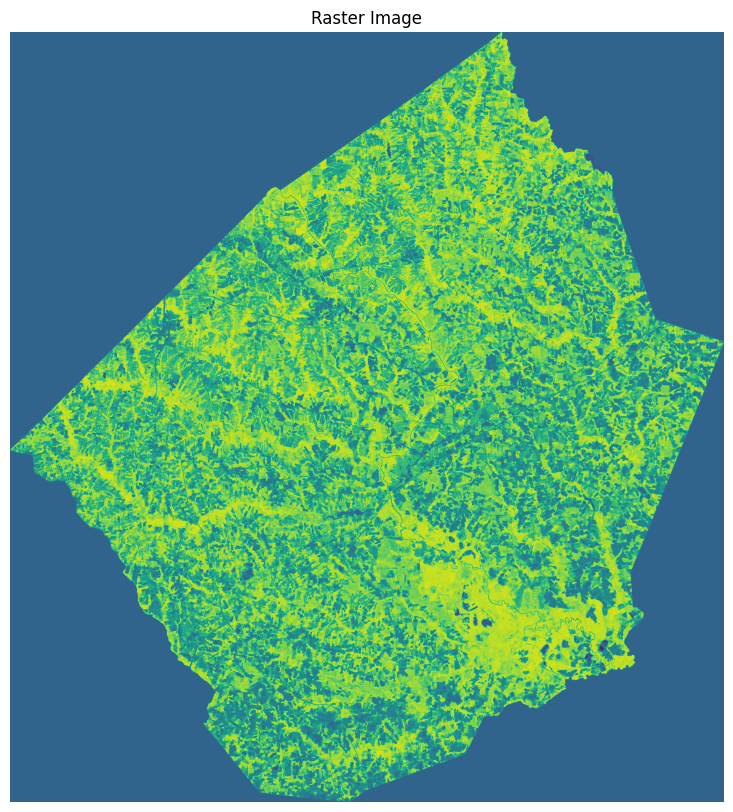

In [5]:
# Plotting Function
import matplotlib.pyplot as plt

def plot_raster(raster_path, title="Raster Image", cmap="viridis"):
    """
    Plots a raster image using matplotlib.

    Args:
    raster_path (str): Path to the raster file.
    title (str): Title of the plot (optional).
    cmap (str): Colormap to use for the plot (optional, default is 'viridis').
    """
    with rasterio.open(raster_path) as src:
        raster_data = src.read(1)
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(raster_data, cmap=cmap)
        ax.set_title(title)
        ax.set_axis_off()
        plt.show()

plot_raster(os.path.join(resampled_path, "2024-05-02T00_00_00_NDVI.tif"))

In [6]:
def normalize_raster(raster_data):
    """
    Normalize raster data to the range [0, 1].

    Args:
    raster_data (numpy.ndarray): The raster data to normalize.

    Returns:
    numpy.ndarray: Normalized raster data.
    """
    raster_min = np.min(raster_data)
    raster_max = np.max(raster_data)
    normalized = (raster_data - raster_min) / (raster_max - raster_min)
    return normalized

def stack_bands(band_paths, output_path, band_names, normalize=True):
    """
    Stack multiple raster bands into a single multi-band raster with metadata for band names.

    Args:
    band_paths (list of str): Paths to the individual band rasters.
    output_path (str): Path to save the stacked raster.
    band_names (list of str): List of descriptive names for each band.
    normalize (bool): Whether to normalize the raster bands (default is True).
    """
    with rasterio.open(band_paths[0]) as src0:
        meta = src0.meta
        meta.update(count=len(band_paths))

    with rasterio.open(output_path, "w", **meta) as dst:
        for id, band in enumerate(band_paths, start=1):
            with rasterio.open(band) as src:
                band_data = src.read(1)  # Read band data
                if normalize:
                    # Normalize raster data prior to adding to the stack
                    band_data = normalize_raster(band_data)
                dst.write(band_data, id)

        # Add band descriptions to metadata
        dst.descriptions = tuple(band_names)  # Assign band names as descriptions

    print(f"Stacked raster with band names saved to {output_path}")

# Set paths and dates
stacked_output_path = os.path.join(output_path, "stacked_rasters")
os.makedirs(stacked_output_path, exist_ok=True)


all_bands = bands # List of bands including NDVI + ["NDVI"]
band_names = ["Blue", "Green", "Red", "NIR"] #, "NDVI"]  # Meaningful names for each band

# Stack for both masked and resampled data
for d in dates:
    # For masked rasters
    masked_band_paths = [os.path.join(masked_path, f"{d}T00_00_00_{b}.tif") for b in all_bands]
    masked_output_file = os.path.join(stacked_output_path, f"{d}_stacked.tif")

    # Check if all bands exist and output doesn't already exist
    if all([os.path.exists(band) for band in masked_band_paths]) and not os.path.exists(masked_output_file):
        stack_bands(masked_band_paths, masked_output_file, band_names, normalize=True)
        print(f"Masked raster for {d} stacked and saved to {masked_output_file}")

    # For resampled rasters
    resampled_band_paths = [os.path.join(resampled_path, f"{d}T00_00_00_{b}.tif") for b in all_bands]
    resampled_output_file = os.path.join(stacked_output_path, f"{d}_stacked_resampled_50.tif")

    # Check if all bands exist and output doesn't already exist
    if all([os.path.exists(band) for band in resampled_band_paths]) and not os.path.exists(resampled_output_file):
        stack_bands(resampled_band_paths, resampled_output_file, band_names, normalize=True)
        print(f"Resampled raster for {d} stacked and saved to {resampled_output_file}")


In [121]:
def pad_raster_to_square_size(raster_path, output_path, divisor=16, pad_value=None):
    """
    Pad the raster to ensure width and height are divisible by `divisor` and are equal in size.
    
    Args:
        raster_path (str): Path to the input raster.
        output_path (str): Path to save the padded raster.
        divisor (int): The value by which width and height must be divisible (default is 16).
        pad_value (float): Value to pad with (e.g., NaN or 0).
    """
    with rasterio.open(raster_path) as src:
        width, height = src.width, src.height
        
        # Calculate the necessary padding to make width and height divisible by divisor
        pad_width = (divisor - (width % divisor)) % divisor
        pad_height = (divisor - (height % divisor)) % divisor

        # Ensure width and height are equal by padding the smaller dimension further
        if (width + pad_width) > (height + pad_height):
            pad_height += (width + pad_width) - (height + pad_height)
        elif (height + pad_height) > (width + pad_width):
            pad_width += (height + pad_height) - (width + pad_width)
        
        # Read the data
        data = src.read(1)  # Reading one band for simplicity; extend for multi-band if needed
        padded_data = np.pad(data, ((0, pad_height), (0, pad_width)), 'constant', constant_values=pad_value)
        
        # Update metadata with new dimensions
        out_meta = src.meta.copy()
        out_meta.update({
            "width": padded_data.shape[1],
            "height": padded_data.shape[0],
            "transform": src.transform
        })
        
        # Save the padded raster
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(padded_data, 1)

    print(f"Padded raster saved to {output_path} with new dimensions: {padded_data.shape}")

# Pad the original stacked rasters
stacked_raster_date_1 = os.path.join(stacked_output_path, f"{dates[0]}_stacked.tif")
padded_output_date_1 = stacked_raster_date_1.replace(".tif", "_padded.tif")
if not os.path.exists(padded_output_date_1):
    pad_raster_to_square_size(stacked_raster_date_1, padded_output_date_1, divisor=16, pad_value=np.nan)

stacked_raster_date_2 = os.path.join(stacked_output_path, f"{dates[1]}_stacked.tif")
padded_output_date_2 = stacked_raster_date_2.replace(".tif", "_padded.tif")
if not os.path.exists(padded_output_date_2):
    pad_raster_to_square_size(stacked_raster_date_2, padded_output_date_2, divisor=16, pad_value=np.nan)

# Repeat for the resampled versions as well
stacked_resampled_raster_date_1 = os.path.join(stacked_output_path, f"{dates[0]}_stacked_resampled_50.tif")
padded_resampled_output_date_1 = stacked_resampled_raster_date_1.replace(".tif", "_padded.tif")
if not os.path.exists(padded_resampled_output_date_1):
    pad_raster_to_square_size(stacked_resampled_raster_date_1, padded_resampled_output_date_1, divisor=16, pad_value=np.nan)

stacked_resampled_raster_date_2 = os.path.join(stacked_output_path, f"{dates[1]}_stacked_resampled_50.tif")
padded_resampled_output_date_2 = stacked_resampled_raster_date_2.replace(".tif", "_padded.tif")
if not os.path.exists(padded_resampled_output_date_2):
    pad_raster_to_square_size(stacked_resampled_raster_date_2, padded_resampled_output_date_2, divisor=16, pad_value=np.nan)


c:\Users\bento\gis582\project\env\Lib\site-packages\numpy\lib\arraypad.py:147: RuntimeWarning: invalid value encountered in cast
  padded[left_slice] = value_pair[0]
c:\Users\bento\gis582\project\env\Lib\site-packages\numpy\lib\arraypad.py:151: RuntimeWarning: invalid value encountered in cast
  padded[right_slice] = value_pair[1]


Padded raster saved to ../data/clay_testing\stacked_rasters\2024-05-02_stacked_padded.tif with new dimensions: (6288, 6288)
Padded raster saved to ../data/clay_testing\stacked_rasters\2024-08-15_stacked_padded.tif with new dimensions: (6288, 6288)
Padded raster saved to ../data/clay_testing\stacked_rasters\2024-05-02_stacked_resampled_50_padded.tif with new dimensions: (3152, 3152)
Padded raster saved to ../data/clay_testing\stacked_rasters\2024-08-15_stacked_resampled_50_padded.tif with new dimensions: (3152, 3152)


In [122]:
# Define latitude, longitude of center of Johnston County, NC
county_boundary = gpd.read_file("../data/county_boundary.shp")
# Reproject to UTM Zone 17N (or a suitable local projection for your area)
county_boundary_utm = county_boundary.to_crs("EPSG:32617")
# Calculate centroid in the projected CRS (UTM)
county_centroid_utm = county_boundary_utm.centroid
# Reproject centroid back to WGS84 to get lat/lon values
county_centroid_wgs84 = county_centroid_utm.to_crs("EPSG:4326")
# Extract latitude and longitude from the centroid
lat_val = county_centroid_wgs84.y.values[0]
lon_val = county_centroid_wgs84.x.values[0]

print(f"Calculated Lat: {lat_val}, Lon: {lon_val}")

# Define paths for stacked rasters (resampled)
resampled_stacked_rasters = [os.path.join(stacked_output_path, f"{dates[0]}_stacked_resampled_50_padded.tif"),
                             os.path.join(stacked_output_path, f"{dates[1]}_stacked_resampled_50_padded.tif")]

# Define dates
date_1 = datetime.strptime(dates[0], '%Y-%m-%d')  # First date
date_2 = datetime.strptime(dates[1], '%Y-%m-%d')  # Second date

# Define Ground Sampling Distance (GSD)
gsd_original = 10  # For non-resampled Sentinel-2 images
gsd_resampled = 20  # 50% resampling of 10m GSD becomes 20m

# Load raster data as numpy arrays
with rasterio.open(resampled_stacked_rasters[0]) as src:
    image_data_date_1 = src.read()  # Read as numpy array

with rasterio.open(resampled_stacked_rasters[1]) as src:
    image_data_date_2 = src.read()  # Read as numpy array


Calculated Lat: 35.517643582086315, Lon: -78.36583290650285


In [74]:
# `git clone https://github.com/Clay-foundation/model.git`
# Download clay-v1-base.ckpt from https://huggingface.co/made-with-clay/Clay/tree/main

# Import libraries
import torch
import sys
sys.path.append("../model")  # Path to cloned repo

# Clay model-specific libraries
from src.model import ClayMAEModule

# Load the pretrained Clay model with metadata
def load_model(ckpt_path, device, metadata_path):
    model = ClayMAEModule.load_from_checkpoint(
        checkpoint_path=ckpt_path,
        map_location=device,
        metadata_path=metadata_path  # Manually providing the metadata file path
    )
    model.eval()  # Set the model to evaluation mode
    return model.to(device)

# Provide the path to your metadata.yaml file
metadata_path = "configs/metadata.yaml"  # Adjust this to the actual location

# Now load the model using the defined function
model = load_model(
    ckpt_path="../clay-ckpt/clay-v1-base.ckpt",  # Path to Clay checkpoint
    device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    metadata_path=metadata_path  # Add this argument to specify the correct path
)

c:\Users\bento\gis582\project\env\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [138]:
def prep_datacube(image, lat, lon, date, gsd, device):
    """
    Prepare the datacube required by the Clay model.

    Args:
        image (np.ndarray): The image data (stacked bands).
        lat (float): Latitude of the location.
        lon (float): Longitude of the location.
        date (datetime): The date of the image.
        gsd (float): Ground sampling distance.
        device (torch.device): The device to run the model on (CPU or GPU).

    Returns:
        dict: Prepared datacube with normalized values and embeddings.
    """
    platform = "sentinel"  # Assume Sentinel as platform, adjust as needed
    
    # Year normalization (assuming a baseline year of 2000, adjust as needed)
    baseline_year = 2000
    year_norm = (date.year - baseline_year) / 100.0  # Normalize year over a century range

    # Month normalization (range [1, 12] -> [0, 1])
    month_norm = (date.month - 1) / 11.0

    # Week of year normalization (range [1, 52] -> [0, 1])
    week_norm = date.isocalendar()[1] / 52.0  # Week of the year

    # Day of the month normalization (range [1, 365] -> [0, 1])
    day_norm = date.isocalendar()[1] / 365.0  # Normalized day of the month
    
    # Latitude and longitude normalization (assuming [-90, 90] and [-180, 180] ranges)
    lat_norm = (lat + 90.0) / 180.0
    lon_norm = (lon + 180.0) / 360.0
    
    # Convert the image to a PyTorch tensor (and send it to the right device)
    # The image shape should be (bands, height, width), so we ensure that it is in the correct shape
    pixels = torch.from_numpy(image.astype(np.float32)).unsqueeze(0).to(device)  # Shape becomes (1, bands, H, W)
    
    # Example placeholder wavelengths for the 4 bands (these should be updated to match your dataset's bands)
    waves = np.array([490, 560, 665, 842], dtype=np.float32)  # for B02, B03, B04, B08
    
    # Prepare the datacube dictionary
    datacube = {
        "platform": platform,
        "time": torch.tensor([[year_norm, day_norm]], 
                             dtype=torch.float32, device=device),  # Shape [1, 4]
        "latlon": torch.tensor([[lat_norm, lon_norm]], dtype=torch.float32, device=device),  # Shape [1, 2]
        "pixels": pixels,  # Shape [1, bands, H, W]
        "gsd": torch.tensor([gsd], dtype=torch.float32, device=device),  # Shape [1]
        "waves": torch.tensor(waves, dtype=torch.float32, device=device)  # Shape [bands]
    }
    
    return datacube


# Prepare datacube for both dates
datacube_date_1 = prep_datacube(
    image=image_data_date_1, 
    lat=lat_val,
    lon=lon_val,
    date=date_1,
    gsd=gsd_resampled,
    device=model.device
)

datacube_date_2 = prep_datacube(
    image=image_data_date_2,
    lat=lat_val,
    lon=lon_val,
    date=date_2,
    gsd=gsd_resampled,
    device=model.device
)

In [139]:
from src.factory import DynamicEmbedding
from src.model import posemb_sincos_2d_with_gsd, repeat

dim = 768
patch_size = 16
patches_embedding = DynamicEmbedding(
    wave_dim=128,
    num_latent_tokens=128,
    patch_size=patch_size,
    embed_dim=dim,
    is_decoder=False,
)

patches, waves_encoded = patches_embedding(datacube_date_1["pixels"], 
                                           datacube_date_1["waves"])


B, L, D = patches.shape
grid_size = int(math.sqrt(L))
num_patches = grid_size**2

pos_encoding = (
    posemb_sincos_2d_with_gsd(
        h=grid_size,
        w=grid_size,
        dim=(dim - 8),
        gsd=datacube_date_1["gsd"],
    )
    .to(patches.device)
    .detach()
) 

In [142]:
# The inputs are meant to be [B 2] and [B 2] (which they are)
time_latlon = torch.hstack((datacube_date_1["time"], 
                            datacube_date_1["latlon"]))\
    .to(patches.device).detach()
# But the output is meant to be [B 8] (it's [B 4])
# This is causing an additional error now that the pixels are square

torch.Size([1, 4])

In [137]:
pos_metadata_encoding = torch.cat(
    (
        repeat(pos_encoding, "L D -> B L D", B=B), 
        repeat(time_latlon, "B D -> B L D", L=L)
    ), 
     dim=-1
)  # [B L D]

patches + pos_metadata_encoding

RuntimeError: The size of tensor a (768) must match the size of tensor b (766) at non-singleton dimension 2

In [76]:
print(image_data_date_1.shape)
print(image_data_date_2.shape)

(4, 3152, 2912)
(4, 3152, 2912)


In [77]:
def generate_embeddings(model, datacube):
    """
    Generate embeddings from the model.

    Args:
        model (ClayMAEModule): The pretrained Clay model.
        datacube (dict): Prepared datacube with input data.

    Returns:
        np.ndarray: The generated embeddings.
    """
    # Assuming the model has an `encoder` method that can take the datacube
    with torch.no_grad():
        # Extract embeddings (you may need to adjust this to match your model's method)
        unmsk_patch, _, _, _ = model.model.encoder(datacube)
        print(f"Unmasked patch shape: {unmsk_patch.shape}")
        
        # The first embedding is the class token, which is the overall embedding
        return unmsk_patch[:, 0, :].cpu().numpy()


# Generate embeddings for both dates
embeddings_date_1 = generate_embeddings(model, datacube_date_1)
embeddings_date_2 = generate_embeddings(model, datacube_date_2)

Patches shape: torch.Size([1, 143416, 768])


RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 142884 but got size 143416 for tensor number 1 in the list.

In [ ]:
def detect_changes(embedding_1, embedding_2, threshold=0.1):
    """
    Detect changes by comparing two embeddings.

    Args:
    embedding_1 (numpy.ndarray): Embeddings from the first date.
    embedding_2 (numpy.ndarray): Embeddings from the second date.
    threshold (float): Threshold for significant changes (default is 0.1).

    Returns:
    numpy.ndarray: Binary map indicating changes.
    """
    diff = np.abs(embedding_1 - embedding_2)
    change_map = (diff > threshold).astype(int)
    return change_map

# Compare embeddings to detect changes
change_map = detect_changes(embeddings_date_1, embeddings_date_2, threshold=0.1)

# Optionally, save or visualize the change map


In [ ]:
def plot_change_map(change_map, title="Change Detection"):
    plt.imshow(change_map, cmap="Reds")
    plt.title(title)
    plt.axis("off")
    plt.show()

# Plot the detected changes
plot_change_map(change_map)
